In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_log_error as rmsle
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import KFold, train_test_split, cross_val_score
import seaborn as sns
import itertools
import optuna
from catboost import CatBoostRegressor, Pool

In [2]:
train = pd.read_csv("train_comp.csv")
test = pd.read_csv("test_comp.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189,82,26,101,41.0,150
1,female,64,163,60,8,85,39.7,34
2,female,51,161,64,7,84,39.8,29
3,male,20,192,90,25,105,40.7,140
4,female,38,166,61,25,102,40.6,146


In [3]:
numerical_features = ["Age","Height","Weight","Duration","Heart_Rate","Body_Temp"]

def add_feats(df, numerical_features):
    ''''''''''
    Inputs: dataframe df
    Output: the modified dataframe with cross terms, BMI, id+calories removed, and sex as categorical variable
    '''''''''
    df_new = df.copy()

    features = df_new.columns

    if 'id' in features:
        df_new = df_new.drop(columns=['id'])
    
    if 'Calories' in features:
        df_new = df_new.drop(columns=['Calories'])
    
    
    df_new['Sex'] = df_new['Sex'].astype('category')

    df_new['BMI'] = df_new['Weight']/((df_new['Height']/100)**2)
    df_new['Body_Temp_-_min_sq'] = (df_new['Body_Temp']-df_new['Body_Temp'].min())**2

    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
            #cross_term_name = f"{feature1}_divided_{feature2}"
            #df_new[cross_term_name] = df_new[feature1] / df_new[feature2]

    return df_new

In [4]:
y = np.log1p(train['Calories'])

X = add_feats(train, numerical_features)

X.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Body_Temp_-_min_sq,Age_x_Height,...,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
0,male,36,189,82,26,101,41.0,22.955684,15.21,6804,...,15498,4914,19089,7749.0,2132,8282,3362.0,2626,1066.0,4141.0
1,female,64,163,60,8,85,39.7,22.582709,6.76,10432,...,9780,1304,13855,6471.1,480,5100,2382.0,680,317.6,3374.5
2,female,51,161,64,7,84,39.8,24.690405,7.29,8211,...,10304,1127,13524,6407.8,448,5376,2547.2,588,278.6,3343.2
3,male,20,192,90,25,105,40.7,24.414062,12.96,3840,...,17280,4800,20160,7814.4,2250,9450,3663.0,2625,1017.5,4273.5
4,female,38,166,61,25,102,40.6,22.136740,12.25,6308,...,10126,4150,16932,6739.6,1525,6222,2476.6,2550,1015.0,4141.2


In [5]:
y = np.log1p(train['Calories'])
X = add_feats(train, numerical_features)

def objective(trial):
    
    params = {
        'iterations': 2000,
        'depth': trial.suggest_int('depth', 9, 14),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, step=0.005),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 1e2, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 1e-8, 1.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree","Depthwise","Lossguide"]),
        'task_type': 'GPU',
        'eval_metric': 'RMSE',
    }




    # Cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=724)
    
    scores = []

    # Perform cross-validation manually
    for train_index, test_index in kf.split(X):
        X_train, X_val = X.loc[train_index], X.loc[test_index]
        y_train, y_val = y.loc[train_index], y.loc[test_index]

        # Initialize the model with the suggested hyperparameters
        model = CatBoostRegressor(
            **params,
            loss_function='RMSE',
            random_state=724,
            verbose=0,
            early_stopping_rounds=40
        )
        
        # Create pool for validation to enable early stopping
        train_pool = Pool(X_train, y_train, cat_features=[0])
        val_pool = Pool(X_val, y_val, cat_features=[0])

        # Train and evaluate
        model.fit(train_pool, eval_set=val_pool, verbose=False, use_best_model=True)
        predictions = model.predict(X_val)
        # print("Stopped at:", model.get_best_iteration())
        
        # Calculate the score
        score = rmse(y_val, predictions)
        scores.append(score)
    

    # Calculate mean RMSE
    error = np.mean(scores)
    return error





if __name__ == "__main__":
    study = optuna.create_study(direction="minimize", study_name='cb_early_stop', storage="sqlite:///catboost.db", load_if_exists=True)
    study.optimize(objective, n_trials=200, timeout=18000)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2025-06-21 17:20:12,729] Using an existing study with name 'cb_early_stop' instead of creating a new one.
[I 2025-06-21 17:20:49,207] Trial 195 finished with value: 0.059995765082036544 and parameters: {'depth': 12, 'learning_rate': 0.08, 'l2_leaf_reg': 0.00033325156906904906, 'bagging_temperature': 0.0003161225632965911, 'border_count': 182, 'grow_policy': 'SymmetricTree'}. Best is trial 192 with value: 0.059539294702456336.
[I 2025-06-21 17:22:33,239] Trial 196 finished with value: 0.05962618816573138 and parameters: {'depth': 12, 'learning_rate': 0.02, 'l2_leaf_reg': 0.00035053263654714656, 'bagging_temperature': 0.00021220166621701645, 'border_count': 187, 'grow_policy': 'SymmetricTree'}. Best is trial 192 with value: 0.059539294702456336.
[I 2025-06-21 17:23:51,971] Trial 197 finished with value: 0.059636866767103926 and parameters: {'depth': 12, 'learning_rate': 0.030000000000000002, 'l2_leaf_reg': 0.0002507167768559009, 'bagging_temperature': 0.00011045449431924622, 'border_c

Number of finished trials:  341
Best trial:
  Value: 0.05952698559201885
  Params: 
    depth: 12
    learning_rate: 0.015
    l2_leaf_reg: 0.00011954668586223026
    bagging_temperature: 4.475008023561076e-05
    border_count: 133
    grow_policy: SymmetricTree


Stopped at: 1762
Train prediction: 0.053417839345673165
Test prediction: 0.059591688349335585


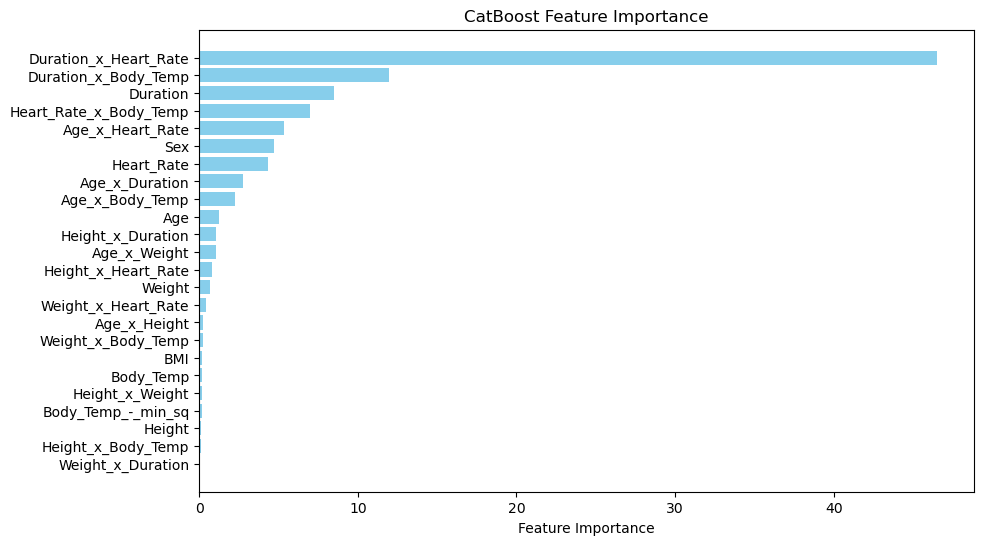

       id    Calories
0  750000   27.642621
1  750001  107.342900
2  750002   88.320039
3  750003  124.895423
4  750004   76.356937

count    250000.000000
mean         88.177840
std          62.273443
min           1.021857
25%          34.015445
50%          76.430247
75%         135.348570
max         300.161225
Name: Calories, dtype: float64


In [ ]:
# Kaggle score private 0.05906, public 0.05742 cb_prediction_10.csv

# Best trial:
#   Value: 0.05952698559201885
#   Params: 
#     depth: 12
#     learning_rate: 0.015
#     l2_leaf_reg: 0.00011954668586223026
#     bagging_temperature: 4.475008023561076e-05
#     border_count: 133
#     grow_policy: SymmetricTree

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=724)

# Define parameters
params = {
        'iterations': 2000,
        'depth': 12,
        'learning_rate': 0.015,
        'l2_leaf_reg': 0.00011954668586223026,
        'bagging_temperature': 4.475008023561076e-05,
        'border_count': 133,
        "grow_policy": "SymmetricTree",
        'task_type': 'GPU',
        'eval_metric': 'RMSE',
    }

# Initialize the model with the suggested hyperparameters
model = CatBoostRegressor(
    **params,
    loss_function='RMSE',
    random_state=724,
    verbose=0,
    early_stopping_rounds=40,
    use_best_model=True,
)

# Create pool for validation to enable early stopping
train_pool = Pool(X_train, y_train, cat_features=[0])
val_pool = Pool(X_test, y_test, cat_features=[0])

# Train and evaluate
model.fit(train_pool, eval_set=val_pool, verbose=False, use_best_model=True)
print("Stopped at:", model.get_best_iteration())


# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Ensure non-negative predictions (important for RMSLE)
train_pred[train_pred < 0] = 1
train_pred[train_pred > 320] = 300
test_pred[test_pred < 0] = 1
test_pred[test_pred > 320] = 300

print("Train prediction:", rmse(train_pred, y_train))
print("Test prediction:", rmse(test_pred, y_test))


# Get feature importances
feature_importances = model.get_feature_importance()

# Get feature names
feature_names = X_train.columns

# Sort feature importances and names
sorted_idx = feature_importances.argsort()
sorted_importances = feature_importances[sorted_idx]
sorted_names = feature_names[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.show()


# make the submission file!
pred = model.predict(add_feats(test, numerical_features))

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("cb_prediction_10.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

Stopped at: 1291
Train prediction: 0.05348970596716411
Test prediction: 0.0596435999999256


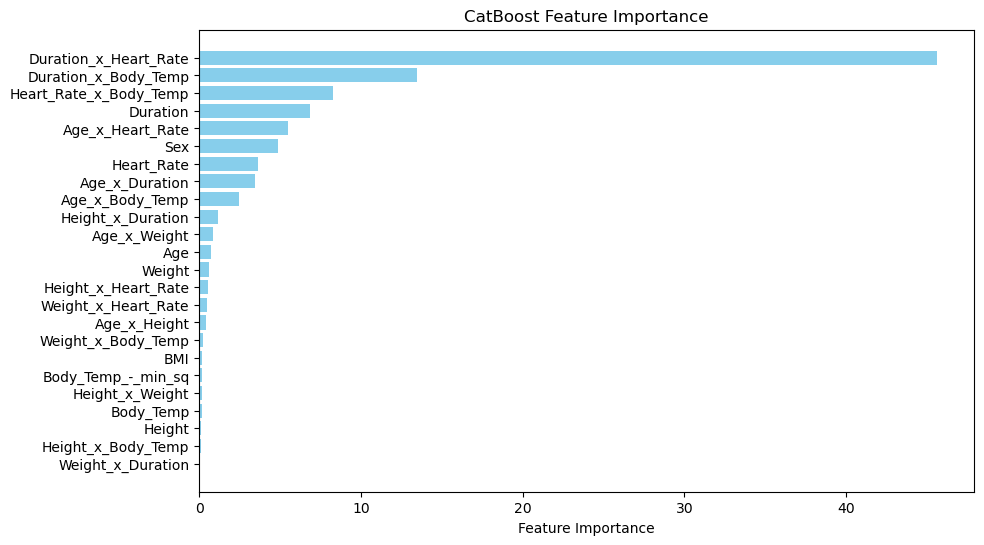

       id    Calories
0  750000   27.468737
1  750001  106.887855
2  750002   87.892779
3  750003  124.535808
4  750004   75.534889

count    250000.000000
mean         88.176367
std          62.271852
min           0.981753
25%          34.004232
50%          76.476909
75%         135.357749
max         295.980605
Name: Calories, dtype: float64


In [ ]:
# Kaggle score private 0.05917, public 0.05748 cb_prediction_9.csv

# Best trial:
#   Value: 0.05954128331946351
#   Params: 
#     depth: 12
#     learning_rate: 0.02
#     l2_leaf_reg: 0.0008937117069387631
#     bagging_temperature: 0.00013382380596995918
#     border_count: 177
#     grow_policy: SymmetricTree

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=724)

# Define parameters
params = {
        'iterations': 2000,
        'depth': 12,
        'learning_rate': 0.02,
        'l2_leaf_reg': 0.0008937117069387631,
        'bagging_temperature': 0.00013382380596995918,
        'border_count': 177,
        "grow_policy": "SymmetricTree",
        'task_type': 'GPU',
        'eval_metric': 'RMSE',
    }

# Initialize the model with the suggested hyperparameters
model = CatBoostRegressor(
    **params,
    loss_function='RMSE',
    random_state=724,
    verbose=0,
    early_stopping_rounds=40,
    use_best_model=True,
)

# Create pool for validation to enable early stopping
train_pool = Pool(X_train, y_train, cat_features=[0])
val_pool = Pool(X_test, y_test, cat_features=[0])

# Train and evaluate
model.fit(train_pool, eval_set=val_pool, verbose=False)
predictions = model.predict(X_test)
print("Stopped at:", model.get_best_iteration())

# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Ensure non-negative predictions (important for RMSLE)
train_pred[train_pred < 0] = 1
train_pred[train_pred > 320] = 300
test_pred[test_pred < 0] = 1
test_pred[test_pred > 320] = 300

print("Train prediction:", rmse(train_pred, y_train))
print("Test prediction:", rmse(test_pred, y_test))


# Get feature importances
feature_importances = model.get_feature_importance()

# Get feature names
feature_names = X_train.columns

# Sort feature importances and names
sorted_idx = feature_importances.argsort()
sorted_importances = feature_importances[sorted_idx]
sorted_names = feature_names[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.show()


# make the submission file!
pred = model.predict(add_feats(test, numerical_features))

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("cb_prediction_9.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

In [7]:
optuna.delete_study(study_name='cb_early_stop', storage="sqlite:///catboost.db")

In [ ]:
def objective(trial):
    
    params = {
        'iterations': trial.suggest_int('iterations', 800, 1300),
        'depth': trial.suggest_int('depth', 9, 14),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 1e2, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 1e-8, 1.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'task_type': 'GPU',
    }



    # Initialize the model with the suggested hyperparameters
    model = CatBoostRegressor(
        **params,
        loss_function='RMSE',
        random_state=724,
        verbose=0,
        early_stopping_rounds=50
    )

    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=724)
    
    scores = []

    # Perform cross-validation manually
    for train_index, test_index in kf.split(X):
        X_train, X_val = X.loc[train_index], X.loc[test_index]
        y_train, y_val = y.loc[train_index], y.loc[test_index]
        
        # Create pool for validation to enable early stopping
        train_pool = Pool(X_train, y_train, cat_features=[0])
        val_pool = Pool(X_val, y_val, cat_features=[0])

        # Train and evaluate
        model.fit(train_pool, eval_set=val_pool, verbose=False)
        predictions = model.predict(X_val)
        
        # Calculate the score
        score = rmse(y_val, predictions)
        scores.append(score)
    

    # Calculate mean RMSE
    error = np.mean(scores)
    return error





if __name__ == "__main__":
    study = optuna.create_study(direction="minimize", study_name='cb_round2_withCV', storage="sqlite:///catboost.db")
    study.optimize(objective, n_trials=200, timeout=18000)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2025-06-02 00:18:00,527] A new study created in RDB with name: cb_round2_withCV
[I 2025-06-02 00:19:21,182] Trial 0 finished with value: 0.05966053826130914 and parameters: {'iterations': 988, 'depth': 11, 'learning_rate': 0.05392055152724044, 'l2_leaf_reg': 0.0014000877836915667, 'bagging_temperature': 0.0023716894145720596, 'border_count': 161}. Best is trial 0 with value: 0.05966053826130914.
[I 2025-06-02 00:20:39,638] Trial 1 finished with value: 0.05997450551172103 and parameters: {'iterations': 1038, 'depth': 10, 'learning_rate': 0.02905662863297788, 'l2_leaf_reg': 25.55272019598837, 'bagging_temperature': 0.02522794817936078, 'border_count': 140}. Best is trial 0 with value: 0.05966053826130914.
[I 2025-06-02 00:22:18,722] Trial 2 finished with value: 0.059854264098322306 and parameters: {'iterations': 1286, 'depth': 10, 'learning_rate': 0.0193511008127426, 'l2_leaf_reg': 12.86025911696981, 'bagging_temperature': 0.0033048648771322846, 'border_count': 201}. Best is trial 0 w

Number of finished trials:  46
Best trial:
  Value: 0.05950511443172714
  Params: 
    iterations: 1120
    depth: 14
    learning_rate: 0.019881973900568724
    l2_leaf_reg: 0.0006419315876022216
    bagging_temperature: 1.0731991179379209e-07
    border_count: 225


In [ ]:
# Best trial:
#   Value: 0.05950511443172714
#   Params: 
#     iterations: 1120
#     depth: 14
#     learning_rate: 0.019881973900568724
#     l2_leaf_reg: 0.0006419315876022216
#     bagging_temperature: 1.0731991179379209e-07
#     border_count: 225

In [26]:
iterations = [250, 350, 500]
learning_rate = [0.15, 0.1, 0.05]
max_depth = [8, 10]                   # 16 is the max
# subsamp = [0.8, 0.9, 1]

model_err = {}

for it, lr, md in itertools.product(iterations, learning_rate, max_depth):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True)

    # Initialize a list to collect accuracy scores
    scores = []

    # Iterate over each fold
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        # dtrain = Pool(X_train, y_train, cat_features=[0])
                
        # Define parameters
        params = {
            'iterations': it,
            'learning_rate': lr,
            'depth': md,                 # max depth is 16
            'loss_function': 'RMSE',
            'eval_metric': 'RMSE',
            'early_stopping_rounds': 25,
            #'subsample': ss,
            'task_type': 'GPU',
            'verbose': -1
        }

        # Initialize and train the model
        model = CatBoostRegressor(**params)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0, cat_features=[0])

        # Predict and evaluate the model
        y_pred = model.predict(X_test)
        y_pred[y_pred <= 0] = 1
        score = rmse(y_test, y_pred)
        scores.append(score)

            
    # Output the mean accuracy over all folds
    print(f"Mean Accuracy for iterations={it}, learn_rate={lr}, max_depth={md}: {np.mean(scores)}")

    model_err[f"iterations_{it}_learn_rate_{lr}_max_depth_{md}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for iterations=250, learn_rate=0.15, max_depth=8: 0.06070390419163293
Mean Accuracy for iterations=250, learn_rate=0.15, max_depth=10: 0.06034111621818853
Mean Accuracy for iterations=250, learn_rate=0.1, max_depth=8: 0.060911950324403184
Mean Accuracy for iterations=250, learn_rate=0.1, max_depth=10: 0.060384622446877055
Mean Accuracy for iterations=250, learn_rate=0.05, max_depth=8: 0.061290269041940994
Mean Accuracy for iterations=250, learn_rate=0.05, max_depth=10: 0.06063883501119431
Mean Accuracy for iterations=350, learn_rate=0.15, max_depth=8: 0.06024992976475446
Mean Accuracy for iterations=350, learn_rate=0.15, max_depth=10: 0.060137042651463114
Mean Accuracy for iterations=350, learn_rate=0.1, max_depth=8: 0.060492436883856485
Mean Accuracy for iterations=350, learn_rate=0.1, max_depth=10: 0.060169569579320015
Mean Accuracy for iterations=350, learn_rate=0.05, max_depth=8: 0.060734082824161595
Mean Accuracy for iterations=350, learn_rate=0.05, max_depth=10: 0.0

In [5]:
iterations = [1000, 1500]
learning_rate = [0.05]
max_depth = [16]                   # 16 is the max
# subsamp = [0.8, 0.9, 1]

model_err = {}

for it, lr, md in itertools.product(iterations, learning_rate, max_depth):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True)

    # Initialize a list to collect accuracy scores
    scores = []

    # Iterate over each fold
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        # dtrain = Pool(X_train, y_train, cat_features=[0])
                
        # Define parameters
        params = {
            'iterations': it,
            'learning_rate': lr,
            'depth': md,                 # max depth is 16
            'loss_function': 'RMSE',
            'eval_metric': 'RMSE',
            'early_stopping_rounds': 50,
            #'subsample': ss,
            'task_type': 'GPU',
            'verbose': -1
        }

        # Initialize and train the model
        model = CatBoostRegressor(**params)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0, cat_features=[0])

        # Predict and evaluate the model
        y_pred = model.predict(X_test)
        y_pred[y_pred <= 0] = 1
        score = rmse(y_test, y_pred)
        scores.append(score)

            
    # Output the mean accuracy over all folds
    print(f"Mean Accuracy for iterations={it}, learn_rate={lr}, max_depth={md}: {np.mean(scores)}")

    model_err[f"iterations_{it}_learn_rate_{lr}_max_depth_{md}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for iterations=1000, learn_rate=0.05, max_depth=16: 0.059965881466992665
Mean Accuracy for iterations=1500, learn_rate=0.05, max_depth=16: 0.05981856534092851
The key with the minimum value is 'iterations_1500_learn_rate_0.05_max_depth_16' with a value of 0.05981856534092851.


0.05288125900138424


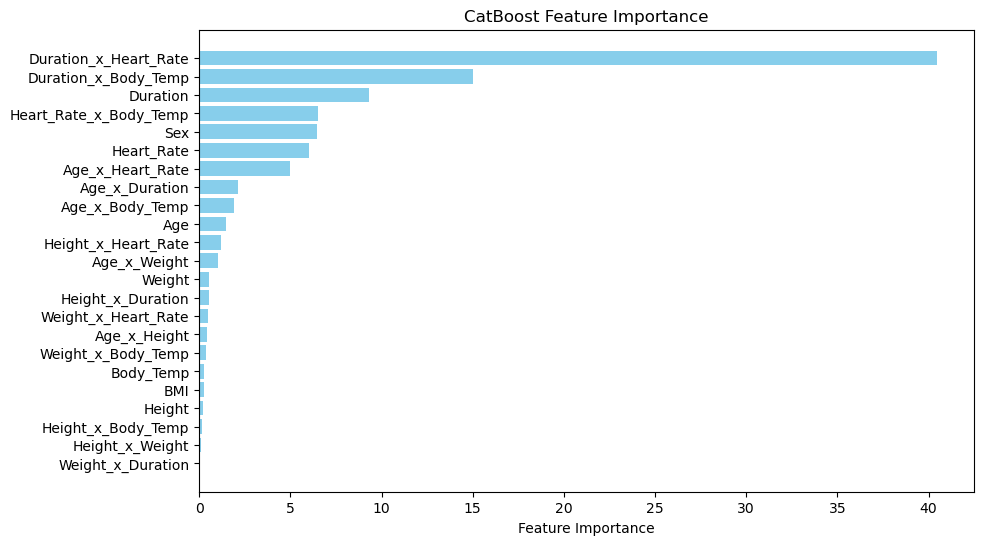

In [ ]:
# Kaggle score 0.05769, cb_prediction_3.csv, iterations 1500, learning rate 0.05, early_stopping_rounds 50, depth 16

num_indices = 600000

train_index = np.random.choice(X.index, size=num_indices, replace=False)
test_index = list(set(np.arange(len(X))) - set(train_index))


X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

# Define parameters
params = {
    'iterations': 1500,
    'learning_rate': 0.05,
    'depth': 16,                 # max depth is 16
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 50,
    #'subsample': ss,
    'task_type': 'GPU',
    'verbose': -1
}

# Train the model
model = CatBoostRegressor(**params)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0, cat_features=[0])

# Make predictions
test_pred = model.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
test_pred[test_pred < 0] = 1

print(rmse(test_pred, y_train))


# Get feature importances
feature_importances = model.get_feature_importance()

# Get feature names
feature_names = X_train.columns

# Sort feature importances and names
sorted_idx = feature_importances.argsort()
sorted_importances = feature_importances[sorted_idx]
sorted_names = feature_names[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.show()

Test prediction: 0.05922324367312883
Train prediction: 0.05346039465352097


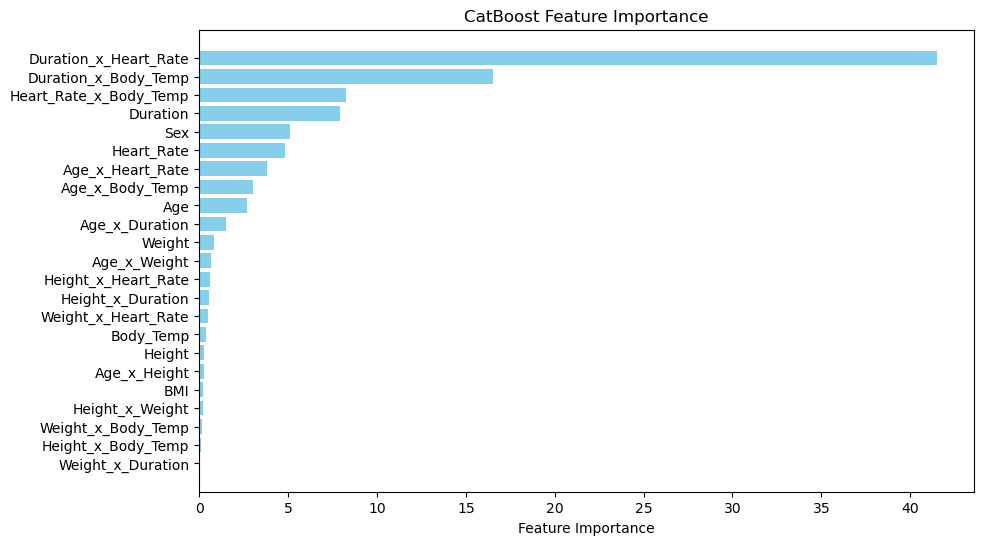

In [ ]:
# Kaggle score 0.05917 priv, 0.05763 public, cb_prediction_6.csv

# Best trial:
#   Value: 0.05950511443172714
#   Params: 
#     iterations: 1120
#     depth: 14
#     learning_rate: 0.019881973900568724
#     l2_leaf_reg: 0.0006419315876022216
#     bagging_temperature: 1.0731991179379209e-07
#     border_count: 225

num_indices = 600000

train_index = np.random.choice(X.index, size=num_indices, replace=False)
test_index = list(set(np.arange(len(X))) - set(train_index))


X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

# Define parameters
params = {
    'iterations': 1120,
    'depth': 14,
    'learning_rate': 0.019881973900568724,
    'l2_leaf_reg': 0.0006419315876022216,
    'bagging_temperature': 1.0731991179379209e-07,
    'border_count': 225,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 50,
    #'subsample': ss,
    'task_type': 'GPU',
    'verbose': -1
}

# Train the model
model = CatBoostRegressor(**params)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0, cat_features=[0])


# Make predictions
y_pred = model.predict(X_test)
y_pred[y_pred <= 0] = 1
print("Test prediction:", rmse(y_test, y_pred))

# Make predictions
train_pred = model.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
train_pred[train_pred < 0] = 1

print("Train prediction:", rmse(train_pred, y_train))


# Get feature importances
feature_importances = model.get_feature_importance()

# Get feature names
feature_names = X_train.columns

# Sort feature importances and names
sorted_idx = feature_importances.argsort()
sorted_importances = feature_importances[sorted_idx]
sorted_names = feature_names[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.show()

Test prediction: 0.060343074400381363
Train prediction: 0.05344072791903854


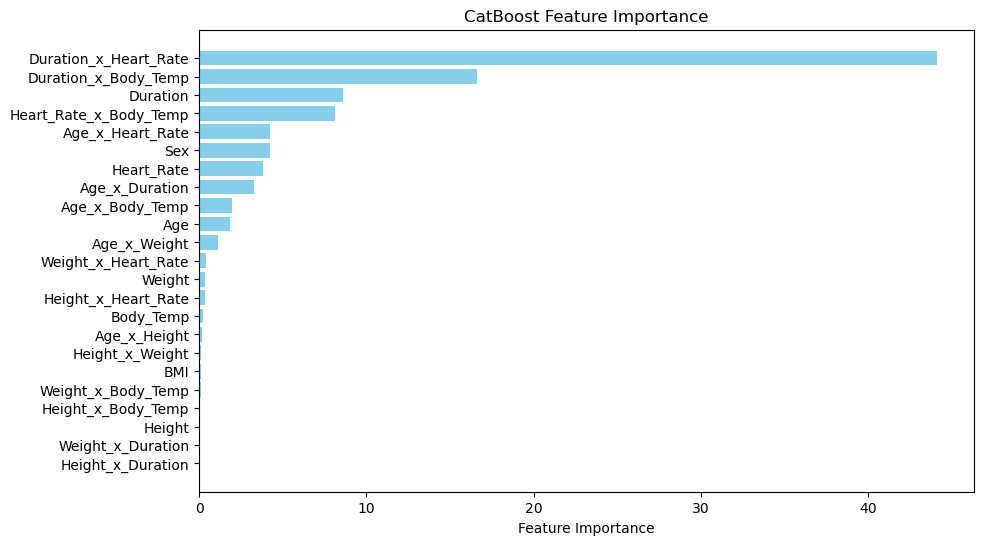

In [ ]:
# Kaggle score 0.05922 priv, 0.05823 public, cb_prediction_5.csv

# Best trial:
#   Value: 0.059658057482489035
#   Params: 
#     iterations: 995
#     depth: 10
#     learning_rate: 0.04444183851602489
#     l2_leaf_reg: 6.361250999342214e-05
#     bagging_temperature: 8.922652276190107e-06
#     border_count: 190

num_indices = 600000

train_index = np.random.choice(X.index, size=num_indices, replace=False)
test_index = list(set(np.arange(len(X))) - set(train_index))


X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

# Define parameters
params = {
    'iterations': 995,
    'depth': 10,
    'learning_rate': 0.04444183851602489,
    'l2_leaf_reg': 6.361250999342214e-05,
    'bagging_temperature': 8.922652276190107e-06,
    'border_count': 190,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 50,
    #'subsample': ss,
    'task_type': 'GPU',
    'verbose': -1
}

# Train the model
model = CatBoostRegressor(**params)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0, cat_features=[0])


# Make predictions
y_pred = model.predict(X_test)
y_pred[y_pred <= 0] = 1
print("Test prediction:", rmse(y_test, y_pred))

# Make predictions
train_pred = model.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
train_pred[train_pred < 0] = 1

print("Train prediction:", rmse(train_pred, y_train))


# Get feature importances
feature_importances = model.get_feature_importance()

# Get feature names
feature_names = X_train.columns

# Sort feature importances and names
sorted_idx = feature_importances.argsort()
sorted_importances = feature_importances[sorted_idx]
sorted_names = feature_names[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.show()

Test prediction: 0.060102237078677
Train prediction: 0.05163711063345169


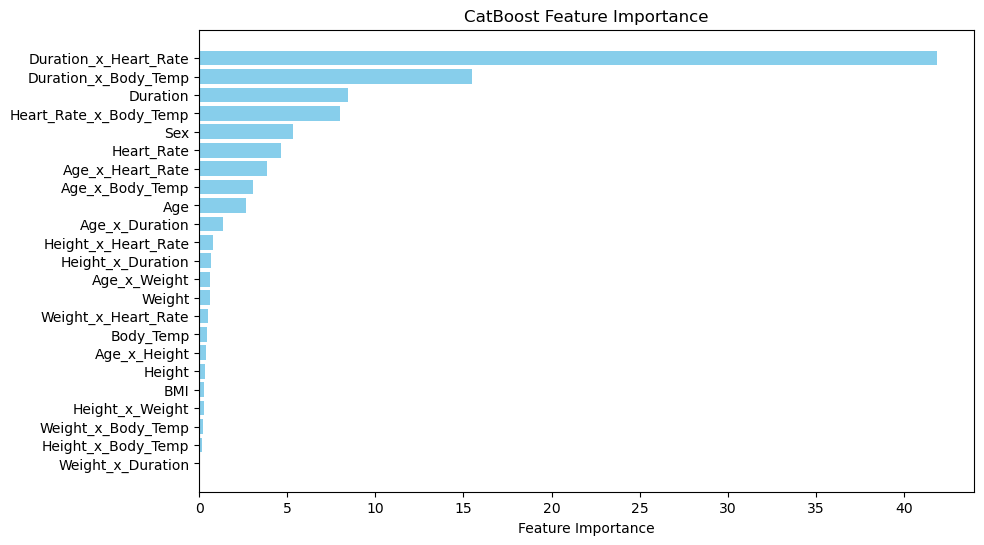

In [ ]:
# Kaggle score 0.05741, cb_prediction_4.csv

# Best trial:
#   Value: 0.0595284511851618
#   Params: 
#     iterations: 1197
#     depth: 14
#     learning_rate: 0.028749323259286183
#     l2_leaf_reg: 0.12260522714595841
#     bagging_temperature: 0.004141526359855983
#     border_count: 130

num_indices = 600000

train_index = np.random.choice(X.index, size=num_indices, replace=False)
test_index = list(set(np.arange(len(X))) - set(train_index))


X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

# Define parameters
params = {
    'iterations': 1197,
    'learning_rate': 0.028749323259286183,
    'depth': 14,
    'l2_leaf_reg': 0.12260522714595841,
    'bagging_temperature': 0.004141526359855983,
    'border_count': 130,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 50,
    #'subsample': ss,
    'task_type': 'GPU',
    'verbose': -1
}

# Train the model
model = CatBoostRegressor(**params)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0, cat_features=[0])


# Make predictions
y_pred = model.predict(X_test)
y_pred[y_pred <= 0] = 1
print("Test prediction:", rmse(y_test, y_pred))

# Make predictions
train_pred = model.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
train_pred[train_pred < 0] = 1

print("Train prediction:", rmse(train_pred, y_train))


# Get feature importances
feature_importances = model.get_feature_importance()

# Get feature names
feature_names = X_train.columns

# Sort feature importances and names
sorted_idx = feature_importances.argsort()
sorted_importances = feature_importances[sorted_idx]
sorted_names = feature_names[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.show()

In [21]:
test_mod = add_feats(test, numerical_features)

test_mod.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Age_x_Height,Age_x_Weight,...,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
0,male,45,177,81,7,87,39.8,25.854639,7965,3645,...,14337,1239,15399,7044.6,567,7047,3223.8,609,278.6,3462.6
1,male,26,200,97,20,101,40.5,24.250000,5200,2522,...,19400,4000,20200,8100.0,1940,9797,3928.5,2020,810.0,4090.5
2,female,29,188,85,16,102,40.4,24.049344,5452,2465,...,15980,3008,19176,7595.2,1360,8670,3434.0,1632,646.4,4120.8
3,female,39,172,73,20,107,40.6,24.675500,6708,2847,...,12556,3440,18404,6983.2,1460,7811,2963.8,2140,812.0,4344.2
4,female,30,173,67,16,94,40.5,22.386314,5190,2010,...,11591,2768,16262,7006.5,1072,6298,2713.5,1504,648.0,3807.0


In [22]:
# make the submission file!

pred = model.predict(test_mod)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test_mod))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("cb_prediction_6.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

       id    Calories
0  750000   27.063890
1  750001  107.331695
2  750002   87.150426
3  750003  124.014188
4  750004   75.896982

count    250000.000000
mean         88.175054
std          62.273936
min           0.975349
25%          34.007909
50%          76.446660
75%         135.374135
max         294.296540
Name: Calories, dtype: float64
